In [1]:
import os
import sys
from pathlib import Path

# Ensure project root is on sys.path so 'backtester' imports work
cwd = Path(os.getcwd())
candidates = [cwd, cwd.parent, Path("..").resolve()]
for p in candidates:
    if (p / "backtester").exists() and str(p) not in sys.path:
        sys.path.insert(0, str(p))
        break

print("PYTHONPATH set. Using root:", sys.path[0])

PYTHONPATH set. Using root: c:\Users\User\Desktop\Crypto strategy backtest


## Load Data

In [2]:
import pandas as pd

def load_crypto_parquet_data(coin_name: str, timeframe: str = "5m", nM: int = 54, section: str = "UTC") -> pd.DataFrame:
    df = pd.read_parquet(fr'C:\Users\User\Desktop\Crypto\{coin_name}_{timeframe}_{nM}M_{section}.parquet')
    return df
def generate_us_session_bars_info(df, include_holidays: bool = False):
    # 確保時間有時區資訊
    df['dt_ny'] = pd.to_datetime(df['dt_utc'], utc=True).dt.tz_convert('America/New_York')

    # 取日期（當地日曆）
    df['date'] = df['dt_ny'].dt.date
    df['weekday'] = df['dt_ny'].dt.day_name() 
    # 對每天依時間排序並編號
    df = df.sort_values(['date', 'dt_ny']).reset_index(drop=True)
    df['bar_index'] = df.groupby('date').cumcount() + 1  # 第幾根K線，從1開始
    if not include_holidays:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    else:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    df = df.loc[df['weekday'].isin(weekday)]
    # 查看結果
    df.set_index('dt_utc', inplace=True)
    # print(df[['dt_ny', 'date', 'weekday', 'bar_index']].head(5))

    return df
def generate_allday_bars_info(df, include_holidays: bool = True):
# 確保時間有時區資訊
    df['dt_ny'] = pd.to_datetime(df['dt_utc'], utc=True).dt.tz_convert('America/New_York')

    # 取日期（當地日曆）
    df['date'] = df['dt_ny'].dt.date
    df['time'] = df['dt_ny'].dt.time
    df['weekday'] = df['dt_ny'].dt.day_name() 
    # 對每天依時間排序並編號
    df = df.sort_values(['date', 'dt_ny']).reset_index(drop=True)
    df['bar_index'] = df.groupby('date').cumcount() + 1  # 第幾根K線，從1開始
    if not include_holidays:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    else:
        weekday = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    df = df.loc[df['weekday'].isin(weekday)]
    # 查看結果
    df.set_index('dt_utc', inplace=True)
    # print(df[['dt_ny', 'date', 'weekday', 'bar_index']].head(5))

    return df

In [3]:
coin_name = 'BTC'  # 可更改為 'ETH', 'SOL', 'BTC', 'ADA', 'PAXG' 等等
nM = 54
timeframe = "5m"
section = "UTC"

df = load_crypto_parquet_data(coin_name=coin_name, timeframe=timeframe, nM=nM, section=section)
df = generate_allday_bars_info(df, include_holidays=False)


## Split Data

In [19]:
# 分成n等分windows
def split_into_windows(df: pd.DataFrame, n_windows: int, overlap_ratio: float = 0.0) -> list[pd.DataFrame]:
    unique_dates = df.index.unique()
    n_dates = len(unique_dates)
    window_size = n_dates // n_windows
    windows = []
    for i in range(n_windows):
        start_idx = i * window_size
        if i == n_windows - 1:  # 最後一個視窗包含剩餘的日期
            end_idx = n_dates
        if overlap_ratio > 0 and i > 0:
            overlap_size = int(window_size * overlap_ratio)
            start_idx -= overlap_size
        end_idx = start_idx + window_size
        window_dates = unique_dates[start_idx:end_idx]
        window_df = df[df.index.isin(window_dates)].copy()
        windows.append(window_df)
    return windows
def split_into_train_test(df: pd.DataFrame, train_pct: float = 0.7) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_dates = df.index.unique()
    n_dates = len(unique_dates)
    train_size = int(n_dates * train_pct)
    train_dates = unique_dates[:train_size]
    test_dates = unique_dates[train_size:]
    train_df = df[df.index.isin(train_dates)].copy()
    test_df = df[df.index.isin(test_dates)].copy()
    return train_df, test_df

In [20]:
splited_dfs = split_into_windows(df, n_windows=5, overlap_ratio=0.5)
splited_train_test_dfs = [split_into_train_test(window_df, train_pct=0.7) for window_df in splited_dfs]

## Build Strategy

In [ ]:
from backtester.models import Position, Side, ActionType, BacktestConfig
from backtester.engine import BacktestEngine
from backtester.strategy_base import StrategyContext
from backtester.strategies.ALBO_strategy import ALBOStrategy, ALBOParams

In [ ]:
cfg = BacktestConfig(initial_cash=10000, fee_rate=0.0, slippage_bps=0.0, conservative_intrabar=True)
engine = BacktestEngine(cfg)

params = ALBOParams(
    break_out_series_n = 3, # BO定義:連續突破K線數
    break_out_n_bars = 10, # 突破區間長度（K線數）
    max_notional_pct = 1.0, # 最大虧損佔資金比例%
    min_qty = 0.001, # 最小BTC下單量
    sl_atr_like = 0.0,  # MVP不做ATR，示範保留欄位
    rr = 2.0,           # TP = SL距離 * rr
    time_exit_bars = 50
)
strategy = ALBOStrategy(params)

result = engine.run(df, strategy)

In [12]:
for trade in result.trades:
    print(trade)
    break

Trade(side=<Side.LONG: 'long'>, qty=0.21352615599324148, entry_time=Timestamp('2021-08-19 22:55:00+0000', tz='UTC'), entry_price=46832.67, exit_time=Timestamp('2021-08-20 13:35:00+0000', tz='UTC'), exit_price=47686.76999999999, exit_type=<ExitType.TP: 'tp'>, pnl=182.3726898338257, bars_held=176)


In [ ]:
trades_df = pd.DataFrame([vars(t) for t in result.trades])
print(trades_df.head())

        side       qty                entry_time  entry_price  \
0  Side.LONG  0.213526 2021-08-19 22:55:00+00:00     46832.67   
1  Side.LONG  0.204679 2021-08-20 21:30:00+00:00     48856.93   
2  Side.LONG  0.203662 2021-08-25 19:05:00+00:00     49101.03   
3  Side.LONG  0.212089 2021-08-26 11:05:00+00:00     47149.99   
4  Side.LONG  0.211343 2021-08-26 21:45:00+00:00     47316.44   

                  exit_time  exit_price    exit_type         pnl  bars_held  
0 2021-08-20 13:35:00+00:00    47686.77  ExitType.TP  182.372690        176  
1 2021-08-20 21:55:00+00:00    49175.57  ExitType.TP   65.218998          5  
2 2021-08-25 19:15:00+00:00    48925.69  ExitType.SL  -35.710045          2  
3 2021-08-26 11:30:00+00:00    46970.94  ExitType.SL  -37.974557          5  
4 2021-08-26 22:00:00+00:00    47163.35  ExitType.SL  -32.354505          3  


Text(0.5, 1.0, 'ALBO Strategy Equity Curve')

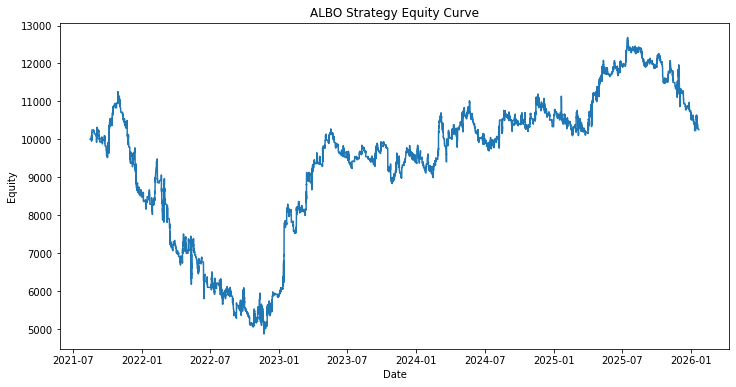

In [16]:
import matplotlib.pyplot as plt
equity_curve = result.equity_curve
plt.figure(figsize=(12,6))
plt.plot(equity_curve.index, equity_curve.values, label='Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('ALBO Strategy Equity Curve')

## 